In [2]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from fit_funcs import *
import costfun.costfun as cost
import utils.figures as fig_help
from RandomMatrixTheory import goe

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:200])
colors_ls_cyc = itertools.cycle(colors_ls)

markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import gamma as Gamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists

DIM = 3
modello = 'Anderson'


def base_dir(model, d):
    """
    Base directory for input model for d-dimension
    """
    dirx = f"../results/{model}/dim={d}/PBC/"
    return dirx

print(base_dir(modello, DIM))

/Users/rafal.swietek/Projects/QHamSolver/Quadratic/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
../results/Anderson/dim=3/PBC/


In [3]:

def order_of_magnitude2(a_value):
    #return 2
    if np.abs(a_value) < 1.0 and a_value != 0:
        m = np.abs(np.log10(np.abs(a_value)))
        return int(max(math.ceil(m) + 1., 2.))
    else: 
        return 2

def order_of_magnitude(a_value):
    x = a_value - int(a_value)
    x = np.round(x, 8)
    num_str = f"{x}"
    num_str = num_str[2:]
    _size = len(num_str)
    if num_str == "0":
        _size = 0;
    
    return _size
    
def info_raw(L, J, w, g, model = 'Anderson', use_old = False):
    
    names = ['J', 'w', 'g']
    arr = [J]
    if model == 'Anderson' or model == 'AubryAndre': arr.append(w)
    if model == 'AubryAndre': arr.append(g)
    
    info = "_L=%d"%(L)
    for i, var in enumerate(arr):
        n = order_of_magnitude2(var) if use_old else order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info

def info(L, J=1.0, w=0.0, g=0.0, use_old = False, model = 'Anderson', ext = '.dat'):
    return info_raw(L, J, w, g, model, use_old) + ext


def GOE(x : np.array):
    """
    GOE shape of sff in thermodynamic limit
    
    Parameters:
    -----------------
        x : np.array
            numpy array with datapoints (times defined for unfolded data)
    """
    return np.array([2 * a - a * np.log(1 + 2 * a) if a < 1 else 2 - a * np.log( (2 * a + 1) / (2 * a - 1) ) for a in x])

def remove_fluctuations(data, bucket_size=10):
    new_data = data;
    half_bucket = int(bucket_size / 2)
    for k in range(half_bucket, len(data) - half_bucket):
        average = np.sum(data[k - half_bucket : k + half_bucket])
        new_data[k - half_bucket] = average / bucket_size
    return new_data


def page(L_a, L_b):
    # return L_a * np.log(2)
    d_a = 2**L_a
    d_b = 2**L_b
    print(d_a, L_a)
    print(d_b, L_b)
    return digamma(d_a * d_b + 1) - digamma(max(d_a, d_b) + 1) - (min(d_a, d_b) - 1) / (2 * max(d_a, d_b))

# ANDERSON

In [3]:
J=1
w = 6
DIM=1

for w in [6.0]:
    # for L in np.arange(4, 18, 2):
    for L in [18, 20, 22]:
        entropy = np.zeros((100))
        single_site_entropy = np.zeros((100))
        counter = 0
        for jobid in np.arange(0, 1, 5):
            name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model = 'Anderson', ext=f'_jobid={jobid}.hdf5')
            if exists(name):
                with h5py.File(name, "r") as file:
                    S = np.array(file.get('entropy')[0])
                    S_site = np.array(file.get('single_site_entropy')[0])

                    entropy += S
                    single_site_entropy += S_site
                    counter += 1
            else:
                print(name)
        if counter > 0:
            name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model='Anderson', ext='.hdf5')

            hf = h5py.File(name, 'w')
            hf.create_dataset('entropy',                entropy.shape,              data = entropy / counter)
            hf.create_dataset('single_site_entropy',    single_site_entropy.shape,  data = single_site_entropy / counter)

            hf.close()


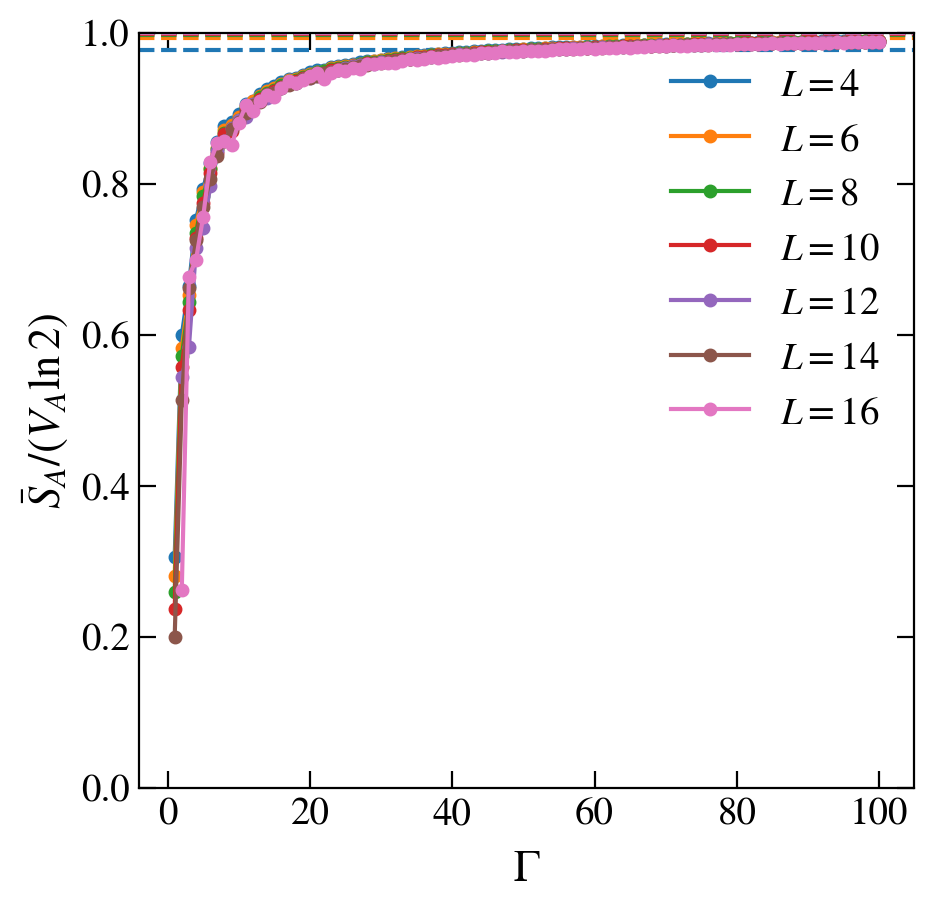

In [28]:
L = 100
w = 27
J = 1
DIM=3


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

# ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.5, 0.46, 0.46])

for L in np.arange(4, 17, 2):
# for L in [20, 50, 100, 500, 1000, 2000]:
    V = L**DIM
    

    name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model='Anderson', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            pl = axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), marker='o', markersize=4, label=r"$L=%d$"%(L))
    else:
        print(name)
    # ax_inset.plot(4 * w_vals, ydata, marker='o', markersize=4, label=r"$L=%d$"%(L))
    axis.axhline(y = 1 - 1. / (V*np.log(2)), color=pl[0].get_color(), ls='--')

fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Gamma$", font_size=14, set_legend=True, ylim=(0.0, 1.0), xscale='linear')
# axis.legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.12,-0.02))

# fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=False, xlim=(8.0, 25.0), ylim=(0.7, 1.0))

fig.subplots_adjust(wspace = 0.2, hspace=0.05)

# AUBRY-ANDRE

In [10]:
J=1
w = 2
g = 3

for w in [1.0, 4.0]:
    for g in [0.618, 1.618]:
        for L in [18, 20, 22]:#np.arange(50, 250, 50):
            entropy = np.zeros((200))
            single_site_entropy = np.zeros((200))
            counter = 0
            for jobid in np.arange(0, 1, 5):
                name = base_dir(model='AubryAndre', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, g=g, model = 'AubryAndre', ext=f'_jobid={jobid}.hdf5')
                if exists(name):
                    with h5py.File(name, "r") as file:
                        S = np.array(file.get('entropy')[0])
                        S_site = np.array(file.get('single_site_entropy')[0])

                        entropy += S
                        single_site_entropy += S_site
                        counter += 1
                else:
                    print(name)
            if counter > 0:
                name = base_dir(model='AubryAndre', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, g=g, model='AubryAndre', ext='.hdf5')

                hf = h5py.File(name, 'w')
                hf.create_dataset('entropy',                entropy.shape,              data = entropy / counter)
                hf.create_dataset('single_site_entropy',    single_site_entropy.shape,  data = single_site_entropy / counter)

                hf.close()


0.5573049591110366


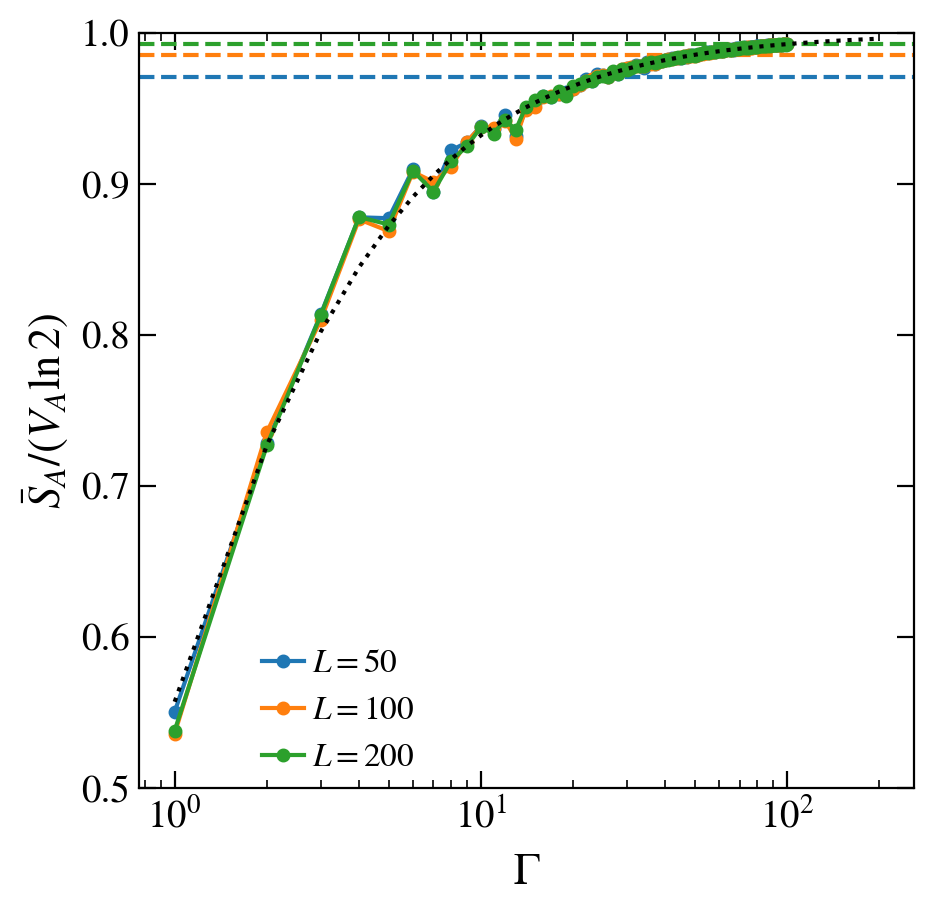

In [162]:
L = 100
w = 1
J = 1
g = 0.618


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

# ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.5, 0.46, 0.46])

gams = np.arange(1,201, 1)
for L in [50, 100, 200]:
    V = L
    

    name = base_dir(model='AubryAndre', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, g=g, model='AubryAndre', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            pl = axis.plot(np.arange(1,S.size+1), S / (V//2*np.log(2)), marker='o', markersize=4, label=r"$L=%d$"%(L))
    else:
        print(name)
    # ax_inset.plot(4 * w_vals, ydata, marker='o', markersize=4, label=r"$L=%d$"%(L))
    axis.axhline(y = 1 - 1. / (V*np.log(2)), color=pl[0].get_color(), ls='--')


def func(f, x):
    return 1 + (1-2*f+x)*np.log(1-2*f/(1+x)) / (2*f)

print(1-(func(1/2, 1)) / np.log(2))
axis.plot(gams, 1 - (func(1/2, gams)) / (np.log(2)), ls=':', color='k')

fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Gamma$", font_size=14, set_legend=True, ylim=(0.5, 1.0), xscale='log')
axis.legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.12,-0.02))

# fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=False, xlim=(8.0, 25.0), ylim=(0.7, 1.0))

fig.subplots_adjust(wspace = 0.2, hspace=0.05)

# SYK2

In [534]:
J=1
w=1
g=1
op=1

prefix = base_dir(model='SYK2', d=1) + 'Entropy/Degeneracy/'
if op == 2:   prefix += "AllStates/"
else:         prefix += "RandomChoice/"

num_gamma = 20
for L in [150]:#np.arange(50, 250, 50):
    entropy = np.zeros((L//2+1, num_gamma))
    single_site_entropy = np.zeros((L//2+1, num_gamma))
    counter = 0
    for jobid in np.arange(0, 1, 5):
        name =  prefix + info(L=L, J=J, w=w, g=g, model = 'SYK2', ext=f'_jobid={jobid}.hdf5')
        if exists(name):
            with h5py.File(name, "r") as file:
                S = np.array(file.get('entropy'))
                S_site = np.array(file.get('single_site_entropy'))

                entropy += S
                single_site_entropy += S_site
                counter += 1
        else:
            print(name)
    if counter > 0:
        name = prefix + info(L=L, J=J, w=w, g=g, model='SYK2', ext='.hdf5')

        hf = h5py.File(name, 'w')
        hf.create_dataset('entropy',                entropy.shape,              data = entropy / counter)
        hf.create_dataset('single_site_entropy',    single_site_entropy.shape,  data = single_site_entropy / counter)

        hf.close()


In [4]:

def borels_triangle(n, k):
    return 1 / n * binom(2*n, n-k-1) * binom(n+k-1, k)

def QC_terms(f, n):
    return f**n * np.sum( [(-1)**k * borels_triangle(n, k) ** f**k for k in range(n)] )

def correction(n=4):
    return np.log(2) - np.sum( [1 / (2 * k * (2 * k - 1)) for k in range(1, n)] )

def gdeg(x, n):    
    if n == 1:      return 2/(1+x)
    elif n == 2:    return 4*(5+x) / ( (1+x)*(2+x)*(3+x) )
    elif n == 3:    return 8*(x**2 + 15*x + 74) / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x) )
    elif n == 4:    return 16*(x**3 + 30*x**2 + 371*x + 2118) / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x)*(6+x)*(7+x) )
    else:           return (2/(1+x))**n

def leading_QC_terms(f, x, n=4):
    res = QC_terms(f, n=1)/2 * gdeg(x, 1)
    if n >= 2:  res += QC_terms(f, n=2) / 12 * gdeg(x,2)
    if n >= 3:  res += QC_terms(f, n=3) / 30 * gdeg(x,3)
    if n >= 4:  res += QC_terms(f, n=4) / 56 * gdeg(x,4)
    # ..... other terms
    return res

def QC_upper_bound(f, x, n):
    return 1 - leading_QC_terms(f, x, n=n) / (np.log(2))

def QC_lower_bound(f, x, n):
    return 1 - (leading_QC_terms(f=f, x=x, n=n) + QC_terms(f=f, n=n) * correction(n=n+1) * gdeg(x=x, n=n)) / (np.log(2))


def QCQ_trace_series(f, x):
    return 1 + (1-2*f+x)*np.log(1-2*f/(1+x)) / (2*f)

def s_QCQ(f, x):
    return 1-(QCQ_trace_series(f, x)) / np.log(2)


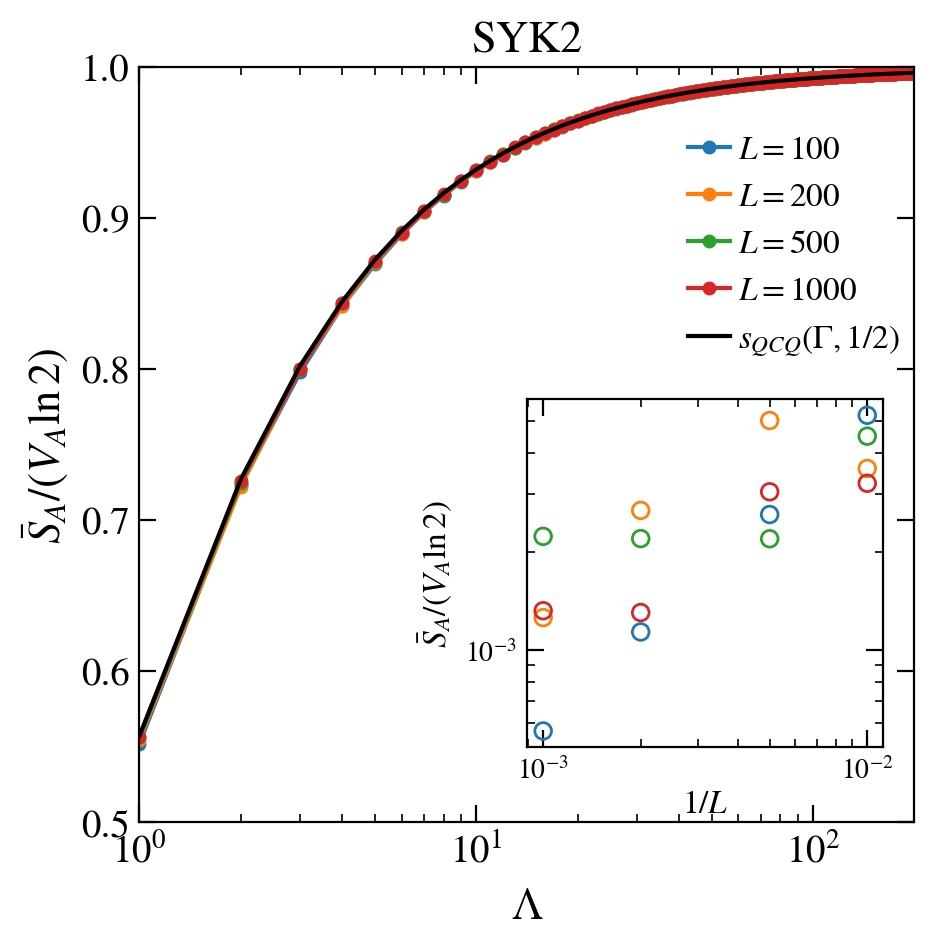

In [5]:
L = 100
w = 1
J = 1
g = 0.618



fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.1, 0.46, 0.46])

op=1

prefix = base_dir(model='SYK2', d=1) + 'Entropy/Degeneracy/'
if op == 2:   prefix += "AllStates/"
else:         prefix += "RandomChoice/"
# ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.5, 0.46, 0.46])

colors_ls_cyc = itertools.cycle(colors_ls)
gams = np.arange(1,201, 1)

sizes = np.array([100, 200, 500, 1000])
S_g1 = []
S_g2 = []
S_g3 = []
S_g4 = []
for L in sizes:
    V = L
    col = next(colors_ls_cyc)

    name = prefix + info(L=L, J=J, w=w, g=g, model='SYK2', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy')) / (V//2*np.log(2))
            xx = np.arange(1,S.size+1)
            pl = axis.plot(xx, S, marker='o', markersize=4, color=col, label=r"$L=%d$"%(L))
            # ax_inset.plot(xx, ( 1 - (s_QCQ(1/2, gams)) / np.log(2)) - S, marker='o', markersize=4, color=col)
            
            S_g1.append(s_QCQ(1/2, 1) - S[0])
            S_g2.append(s_QCQ(1/2, 2) - S[1])
            S_g3.append(s_QCQ(1/2, 3) - S[2])
            S_g4.append(s_QCQ(1/2, 4) - S[3])
    else:
        S_g1.append(np.nan)
        S_g2.append(np.nan)
        S_g3.append(np.nan)
        S_g4.append(np.nan)
        print(name)
    # ax_inset.plot(4 * w_vals, ydata, marker='o', markersize=4, label=r"$L=%d$"%(L))
    # axis.axhline(y = 1 - 1. / (V*np.log(2)), color=col, ls='--')



colors_ls_cyc = itertools.cycle(colors_ls)

for gamma, ent in enumerate([S_g1, S_g2, S_g3, S_g4]):
    col = next(colors_ls_cyc)
    ax_inset.scatter(1./sizes, ent, color=col, marker='o', facecolor='None', label=r"$\Gamma=%d$"%(gamma+1))
    
    pars, pconv = fit(lin_fit,
                    xdata = 1./sizes,
                    ydata = ent)
    xx = np.linspace(0, 1.5/min(sizes), 1000)
    # ax_inset.plot(xx, lin_fit(xx, *pars), ls='--', color = col)
    # ax_inset.axhline(y=s_QCQ(1/2, gamma + 1), ls=':', color=col)


# ax_inset.plot(gams, 1e-2/gams**1.5, ls='--', c='k')
order=4
# axis.plot(gams, QC_upper_bound(1/2, gams, order), ls=':', color='k', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
# axis.plot(gams, QC_lower_bound(1/2, gams, order), ls='--', color='k', label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)

axis.plot(gams, s_QCQ(1/2, gams), ls='-', color='k', label=r'$s_{QCQ}(\Gamma,1/2)$')

fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Lambda$", font_size=14, set_legend=True, ylim=(0.5, 1.0), xlim=(1, 200), xscale='log', yscale='linear')
axis.legend(loc = 'upper right', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02,0.95))

fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$1/L$", font_size=10, set_legend=False, xscale='log', yscale='log')
# ax_inset.legend(loc = 'center right', columnspacing=0.4, frameon=False, fontsize=8, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02,0.35))

axis.set_title(r"SYK$2$", fontsize=16)
# fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=False, xlim=(8.0, 25.0), ylim=(0.7, 1.0))

fig.subplots_adjust(wspace = 0.2, hspace=0.05)


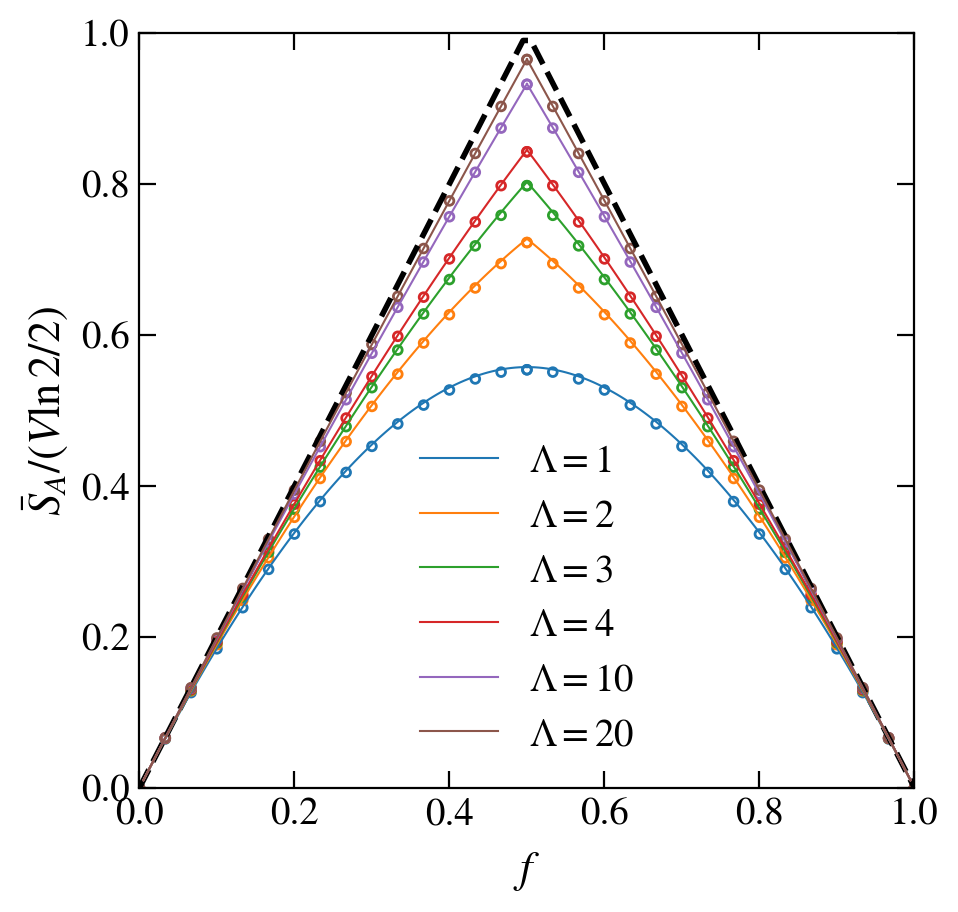

In [539]:
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

ff = np.linspace(0, 1.0, 100)
axis.plot(ff, 1 - 2*np.abs(0.5 - ff), ls='--', color='k', lw=2)

# ff = np.linspace(0., 0.5, 100)
# axis.plot(ff, 2 * ff * (1 - (1 + (1-ff)/ff * np.log(1-ff) ) / np.log(2)), ls=':', color='black')
# ff = np.linspace(.5, 1., 100)
# axis.plot(ff, 2 * (1-ff) * (1 - (1 + ff/(1-ff) * np.log(ff) ) / np.log(2)), ls=':', color='black')    

colors_ls_cyc = itertools.cycle(colors_ls)

L=150
V=L
name = prefix + info(L=L, J=J, w=w, g=g, model='SYK2', ext='.hdf5')
# print(name)
if exists(name):
    with h5py.File(name, "r") as file:
        S = np.array(file.get('entropy')) / (V//2*np.log(2))
        # print(S)
subsizes = np.linspace(0, L//2, L//2+1)


for gam in [1,2,3,4,10,20]:
    col = next(colors_ls_cyc)

    ff = np.linspace(0, 0.5, 100)
    axis.plot(ff, 2 * ff * ( 1 - (s_QCQ(ff, gam)) / (np.log(2)) ), ls='-', color=col, label=r"$\Lambda=%d$"%gam, lw=0.75)
    
    ff = np.linspace(0.5, 1.0, 100)
    axis.plot(ff, 2 * (1-ff) * ( 1 - (s_QCQ(1-ff, gam)) / (np.log(2)) ), ls='-', color=col, lw=0.75)

    axis.scatter(subsizes[::5] / L, S[::5,gam - 1], color=col, s=10, facecolor='None')
    axis.scatter(1 - subsizes[::5] / L, S[::5,gam - 1], color=col, s=10, facecolor='None')

fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V\ln2/2)$", xlabel=r"$f$", font_size=14, set_legend=True, xlim=(0,1), ylim=(0,1), xscale='linear', yscale='linear')


# FREE FERMIONS

In [389]:
J=1
w=1
g=1
op=1

prefix = base_dir(model='FreeFermions', d=1) + 'Entropy/Degeneracy/'
if op == 0:     prefix += "E=0,Q=0/"
elif op == 2:   prefix += "AllStates/"
else:           prefix += "RandomChoice/"
for L in [2000]:#np.arange(50, 250, 50):
    entropy = np.zeros((200))
    single_site_entropy = np.zeros((200))
    counter = 0
    for jobid in np.arange(0, 1, 5):
        name =  prefix + info(L=L, J=J, w=w, g=g, model = 'FreeFermions', ext=f'_jobid={jobid}.hdf5')
        if exists(name):
            with h5py.File(name, "r") as file:
                S = np.array(file.get('entropy')[0])
                S_site = np.array(file.get('single_site_entropy')[0])

                entropy += S
                single_site_entropy += S_site
                counter += 1
        else:
            print(name)
    if counter > 0:
        name = prefix + info(L=L, J=J, w=w, g=g, model='SYK2', ext='.hdf5')

        hf = h5py.File(name, 'w')
        hf.create_dataset('entropy',                entropy.shape,              data = entropy / counter)
        hf.create_dataset('single_site_entropy',    single_site_entropy.shape,  data = single_site_entropy / counter)

        hf.close()


In [458]:

def FF_terms(f, x, n):
    # if n == 1:  return f
    # if n == 2:  return 8/3 * f**2 - 2 * f**3
    # if n == 3:  return 11 * f**3 - 24 * f**4 + 16 * f**5
    # if n == 4:  
    #     res = 908/15 * f**4 - 1296/5 * f**5 + 27320/63 * f**6 - 272 * f**7
    #     if f >= 1/4 and f < 1/3: res += 8192/315*f**6 - 2048/45*f**5 + 512/15*f**4 - 128/9*f**3 + 32/9*f**2 - 8/15*f + 2/45 - 1/(630*f)
    #     if f >= 1/3 and f <= 1/2: res += 12136/63*f**6 - 13712/45*f**5 + 556/3*f**4 - 452/9*f**3 + 32/9*f**2 + 16/15*f - 2/9 + 1/(90*f)
    #     return res
    # else:       return 0
    # if n == 1:  return 2/(1+x) * f
    # if n == 2:  return 8/3 * 4*(5+x) / ( (1+x)*(2+x)*(3+x) ) * f**2 + 2 * 12/( (2+x)*(3+x) ) * f**3
    # if n == 3:  return (11 * 8*(x**2 + 15*x + 74) * f**3 - 24 * 24*(x + 14)*(x + 1) * f**4 + 16 * 120*(x+1)*(x+2) * f**5 ) / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x) )
    # if n == 4:  
    #     res = 908/15  * 16*(x**3 + 30*x**2 + 371*x + 2118)    / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x)*(x+6)*(x+7) ) * f**4\
    #                 -   1296/5  * 24*(x + 9)                            / ( (1+x)*(3+x)*(4+x)*(5+x) )                   * f**5\
    #                 +   5816/63 * 144*(x**3 + 22*x**2 + 123*x + 134)    / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x)*(x+6)*(x+7) ) * f**6\
    #                 +   1024/3  * 240*(x + 13)                          / ( (1+x)*(4+x)*(5+x)*(x+6)*(x+7) )             * f**6\
    #                 -   272     * 1680                                  / ( (4+x)*(5+x)*(x+6)*(x+7) )                   * f**7
    #     if f >= 1/4 and f < 1/3:    res += (8192/315*f**6 - 2048/45*f**5 + 512/15*f**4 - 128/9*f**3 + 32/9*f**2 - 8/15*f + 2/45 - 1/(630*f)) * 144*(x**3 + 22*x**2 + 123*x + 134)   / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x)*(x+6)*(x+7) ) 
    #     if f >= 1/3 and f <= 1/2:   res += (12136/63*f**6 - 13712/45*f**5 + 556/3*f**4 - 452/9*f**3 + 32/9*f**2 + 16/15*f - 2/9 + 1/(90*f)) * 144*(x**3 + 22*x**2 + 123*x + 134)    / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x)*(x+6)*(x+7) )
    #     return res
    # else:       return 0

    if n == 1:  return 2/(1+x) * f
    if n == 2:  return (8/3 * f**2 - 3*f**3) * 4*(5+x) / ( (1+x)*(2+x)*(3+x) ) + 12/( (2+x)*(3+x) ) * f**3
    if n == 3:  return ( (11*f**3 - 36*f**4 + 30*f**5) * 8*(x**2 + 15*x + 74) + (12*f**4 - 15*f**5) * 24*(x + 14)*(x + 1) + f**5 * 120*(x+1)*(x+2)) / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x) )
    if n == 4:  
        res = 908/15  * 16*(x**3 + 30*x**2 + 371*x + 2118)    / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x)*(x+6)*(x+7) ) * f**4\
                    -   1296/5  * 24*(x + 9)                            / ( (1+x)*(3+x)*(4+x)*(5+x) )                   * f**5\
                    +   5816/63 * 144*(x**3 + 22*x**2 + 123*x + 134)    / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x)*(x+6)*(x+7) ) * f**6\
                    +   1024/3  * 240*(x + 13)                          / ( (1+x)*(4+x)*(5+x)*(x+6)*(x+7) )             * f**6\
                    -   272     * 1680                                  / ( (4+x)*(5+x)*(x+6)*(x+7) )                   * f**7
        if f >= 1/4 and f < 1/3:    res += (8192/315*f**6 - 2048/45*f**5 + 512/15*f**4 - 128/9*f**3 + 32/9*f**2 - 8/15*f + 2/45 - 1/(630*f)) * 144*(x**3 + 22*x**2 + 123*x + 134)   / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x)*(x+6)*(x+7) ) 
        if f >= 1/3 and f <= 1/2:   res += (12136/63*f**6 - 13712/45*f**5 + 556/3*f**4 - 452/9*f**3 + 32/9*f**2 + 16/15*f - 2/9 + 1/(90*f)) * 144*(x**3 + 22*x**2 + 123*x + 134)    / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x)*(x+6)*(x+7) )
        return res
    else:       return 0

    # if n == 1:  return 2/(1+x) * f
    # if n == 2:  return 8/3 * (2 / (1+x))**2 * f**2 - 2 * 12*(x**2 + x + 2)/( (1+x)**2*(2+x)*(3+x) ) * f**3 
    # if n == 3:  return (11 * (2/(1+x))**3 * f**3 - 24 * 24*(x**2 + x + 2)/( (1+x)**3*(2+x)*(3+x) ) * f**4 + 16 * 120*(x**4 + 2*x**3 + 47*x**2 - 2*x - 24)/( (1+x)**3*(2+x)*(3+x)*(4+x)*(5+x) )  * f**5 )
    # if n == 4:  
    #     res = 908/15 * (2/(1+x))**4                                                                                                                                                     * f**4\
    #                 -   1296/5  * 48*(x**2 + x + 2)                                                                                   /( (1+x)**4*(2+x)*(3+x) )                         * f**5\
    #                 +   5816/63 * 144*(x**2 + x + 2)**2                                                                               /( (1+x)**2*(2+x)*(3+x) )**2                      * f**6\
    #                 +   1024/3  * 240*(x**4 + 2*x**3 + 47*x**2 - 2*x - 24)                                                            /( (1+x)**4*(2+x)*(3+x)*(4+x)*(5+x) )             * f**6\
    #                 -   272     * 1680*(x**8 + 8*x**7 + 196*x**6 - 2122*x**5 - 15713*x**4 - 22438*x**3 + 10188*x**2 + 24984*x + 7200) / ( (1+x)**4*(2+x)**2*(3+x)**2*(4+x)*(5+x)*(x+6)*(x+7) )   * f**7
    #     # if f >= 1/4 and f < 1/3:    res += (8192/315*f**6 - 2048/45*f**5 + 512/15*f**4 - 128/9*f**3 + 32/9*f**2 - 8/15*f + 2/45 - 1/(630*f)) * 144*(x**2 + x + 2)**2 /( (1+x)**2*(2+x)*(3+x) )**2
    #     # if f >= 1/3 and f <= 1/2:   res += (12136/63*f**6 - 13712/45*f**5 + 556/3*f**4 - 452/9*f**3 + 32/9*f**2 + 16/15*f - 2/9 + 1/(90*f)) * 144*(x**2 + x + 2)**2 /( (1+x)**2*(2+x)*(3+x) )**2
    #     return res
    # else:       return 0

def correction(n=4):
    return np.log(2) - np.sum( [1 / (2 * k * (2 * k - 1)) for k in range(1, n)] )

def gdeg(x, n):    
    return 1.0#(2/(1+x))**n
    if n == 1:      return 2/(1+x)
    elif n == 2:    return 4*(5+x) / ( (1+x)*(2+x)*(3+x) )
    elif n == 3:    return 8*(x**2 + 15*x + 74) / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x) )
    elif n == 4:    return 16*(x**3 + 30*x**2 + 371*x + 2118) / ( (1+x)*(2+x)*(3+x)*(4+x)*(5+x)*(6+x)*(7+x) )
    else:           return 1

def leading_FF_terms(f, x, n=4):
    # res = FF_terms(f, x, n=1)/2 * gdeg(x, 1)
    # if n >= 2:  res += FF_terms(f, x, n=2) / 12 * gdeg(x,2)
    # if n >= 3:  res += FF_terms(f, x, n=3) / 30 * gdeg(x,3)
    # if n >= 4:  res += FF_terms(f, x, n=4) / 56 * gdeg(x,4)
    # ..... other terms

    res = FF_terms(f=f, x=x, n=1) / 2
    if n >= 2:  res += FF_terms(f=f, x=x, n=2) / 12
    if n >= 3:  res += FF_terms(f=f, x=x, n=3) / 30
    if n >= 4:  res += FF_terms(f=f, x=x, n=4) / 56
    return res

def FF_upper_bound(f, x, n):
    return 1 - leading_FF_terms(f, x, n=n) / (np.log(2))

def FF_lower_bound(f, x, n):
    return 1 - (leading_FF_terms(f=f, x=x, n=n) + FF_terms(f=f, x=x, n=n) * correction(n=n+1) * gdeg(x, n)) / (np.log(2))



0.532624438560235 0.5621923531315911


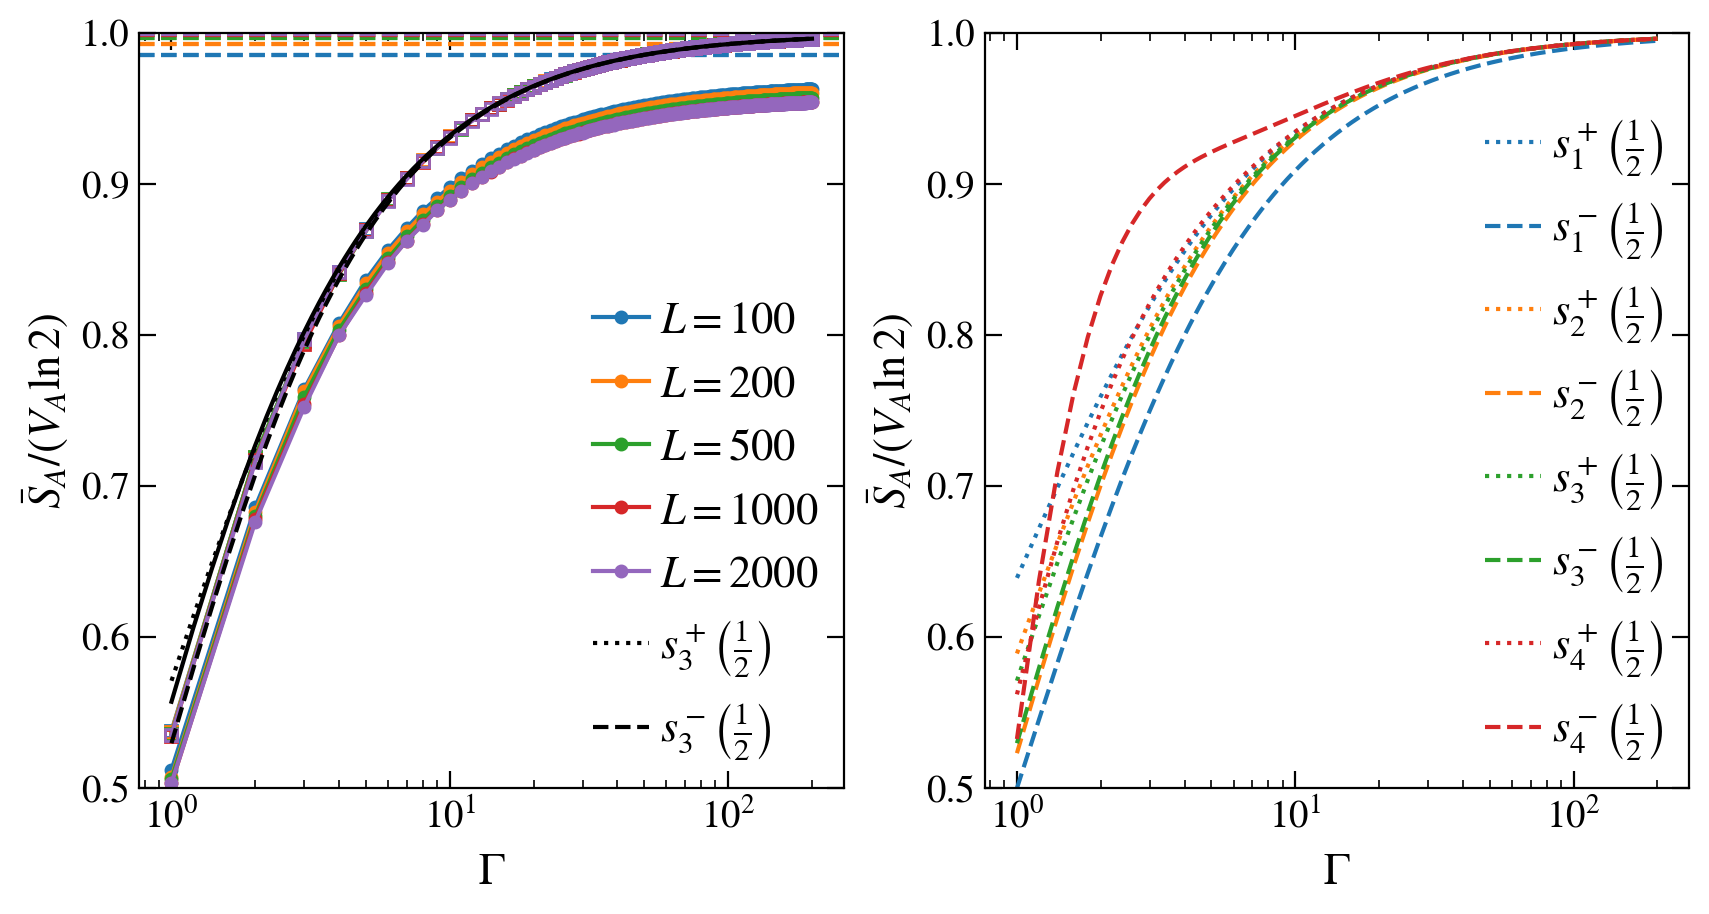

In [459]:
L = 200
w = 1
J = 1
g = 1.618
op=0

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)

axis = ax[0]
axis2 = ax[1]
# ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.5, 0.46, 0.46])

gams = np.linspace(1, 200, 1000)

colors_ls_cyc = itertools.cycle(colors_ls)
for L in [100, 200, 500, 1000,2000]:
    col = next(colors_ls_cyc)
    for op in [0, 1]:
    # if True:
        V = L
        

        name = base_dir(model='FreeFermions', d=1) + 'Entropy/Degeneracy/'
        if op == 0:     name += "E=0,Q=0/"
        elif op == 2:   name += "AllStates/"
        else:           name += "RandomChoice/"
        name +=  info(L=L, J=J, model='FreeFermions', ext='.hdf5')
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                S = np.array(file.get('entropy'))
                if op == 0: 
                    pl = axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='o', markersize=4, label=r"$L=%d$"%(L))
                else:
                    pl = axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='s', markerfacecolor='None', markersize=4)
        else:
            print(name)
        # ax_inset.plot(4 * w_vals, ydata, marker='o', markersize=4, label=r"$L=%d$"%(L))
        axis.axhline(y = 1 - 1. / (V*np.log(2)), color=pl[0].get_color(), ls='--')


n = 3   # correction order

print(FF_lower_bound(1/2, 1, 4), FF_upper_bound(1/2, 1, 4))

axis.plot(gams, FF_upper_bound(1/2, gams, n), ls=':', color='k', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
axis.plot(gams, FF_lower_bound(1/2, gams, n), ls='--', color='k', label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)
# axis.plot(gams, 1 - (func(1/2, gams)) / (np.log(2)), ls='-', color='black', lw=2)


fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Gamma$", font_size=14, set_legend=True, ylim=(0.5, 1.0), xscale='log')
axis.legend(loc = 'lower right', columnspacing=0.4, frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02,-0.02))

# fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=False, xlim=(8.0, 25.0), ylim=(0.7, 1.0))

axis.plot(gams, 1 - (func(1/2, gams)) / (np.log(2)), ls='-', color='k')
fig.subplots_adjust(wspace = 0.2, hspace=0.05)

# axis.plot(gams, Gamma(gams-1) / Gamma)
n=1
p = axis2.plot(gams, FF_upper_bound(1/2, gams, n), ls=':', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
axis2.plot(gams, FF_lower_bound(1/2, gams, n), ls='--', color=p[0].get_color(), label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)
n=2
p = axis2.plot(gams, FF_upper_bound(1/2, gams, n), ls=':', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
axis2.plot(gams, FF_lower_bound(1/2, gams, n), ls='--', color=p[0].get_color(), label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)
n=3
p = axis2.plot(gams, FF_upper_bound(1/2, gams, n), ls=':', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
axis2.plot(gams, FF_lower_bound(1/2, gams, n), ls='--', color=p[0].get_color(), label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)
n=4
p = axis2.plot(gams, FF_upper_bound(1/2, gams, n), ls=':', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
axis2.plot(gams, FF_lower_bound(1/2, gams, n), ls='--', color=p[0].get_color(), label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)


fig_help.set_plot_elements(axis2, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Gamma$", font_size=14, set_legend=True, ylim=(0.5, 1.0), xscale='log')
axis2.legend(loc = 'lower right', columnspacing=0.4, frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02,-0.02))

In [471]:
1454+21*64

2798

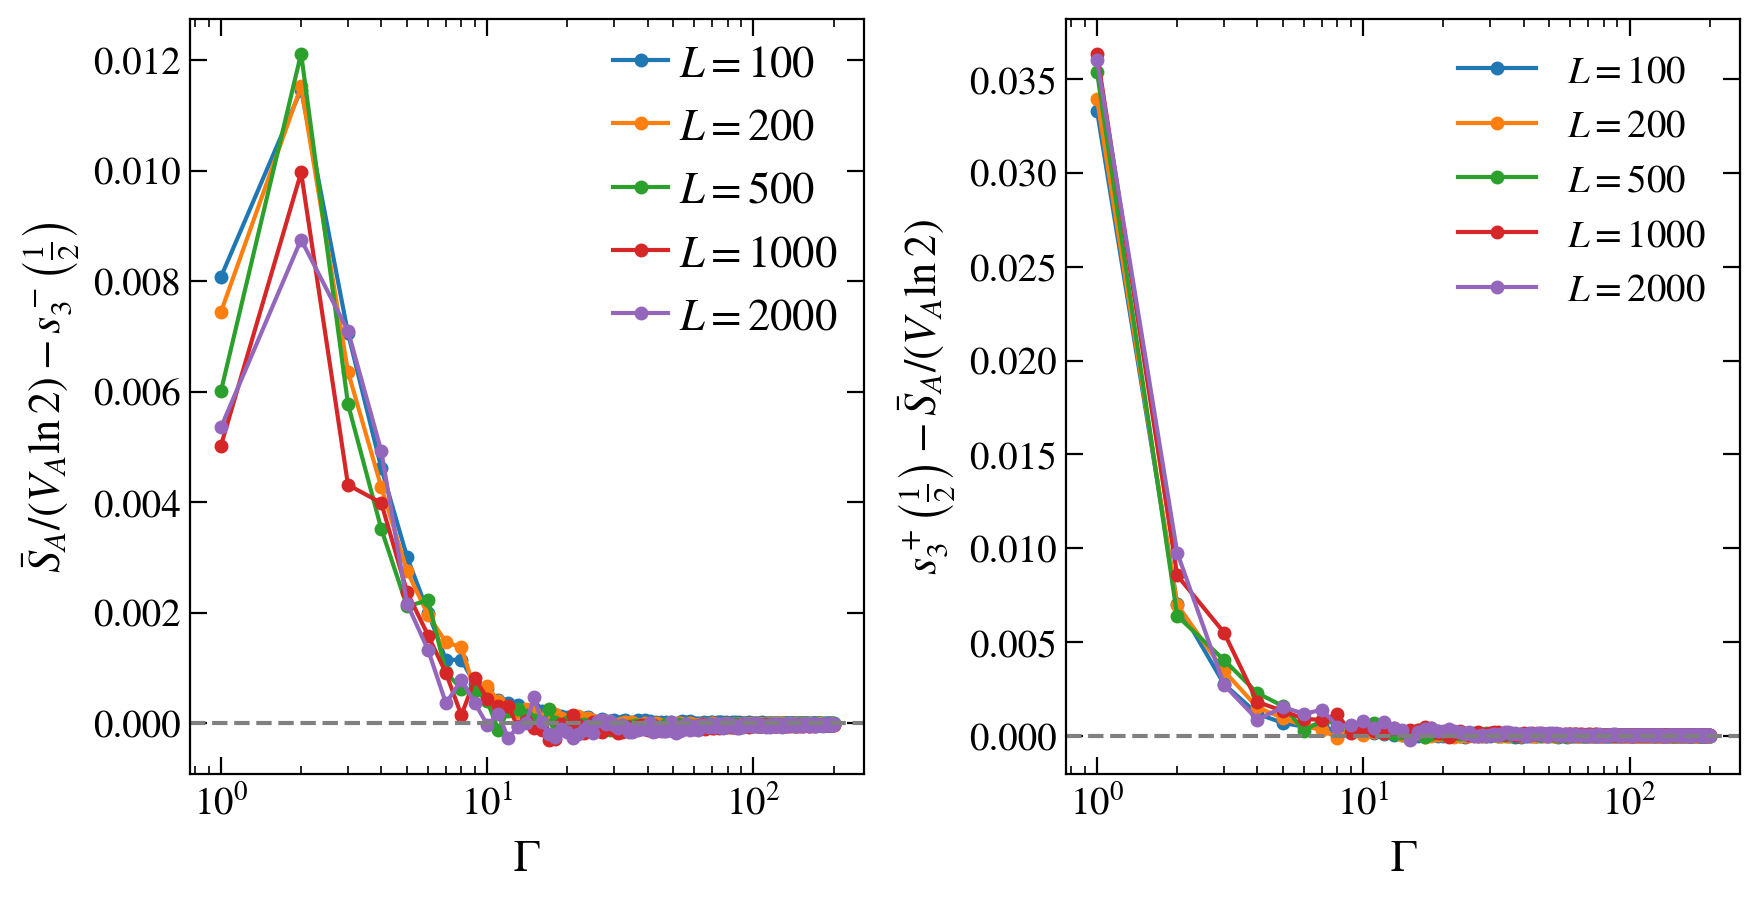

In [472]:
L = 500
w = 1
J = 1
g = 1.618


fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)
axis=ax[0]
axis2=ax[1]

colors_ls_cyc = itertools.cycle(colors_ls)

for L in [100, 200, 500, 1000,2000]:
    col = next(colors_ls_cyc)
    op = 1
    V = L


    n = 3   # correction order

    name = base_dir(model='FreeFermions', d=1) + 'Entropy/Degeneracy/'
    if op == 0:     name += "E=0,Q=0/"
    elif op == 2:   name += "AllStates/"
    else:           name += "RandomChoice/"
    name +=  info(L=L, J=J, model='FreeFermions', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            gams = np.linspace(1, 200, S.size)
            pl = axis.plot(np.arange(1,S.size+1, 1), (S / (V//2*np.log(2)) - FF_lower_bound(1/2, gams, n)), color=col, marker='o', markersize=4, label=r"$L=%d$"%(L))
            # axis.set_ylim(1.1 * min((S / (V//2*np.log(2)) - FF_lower_bound(1/2, gams, n))), 1.1 * max((S / (V//2*np.log(2)) - FF_lower_bound(1/2, gams, n))))
            
            axis2.plot(np.arange(1,S.size+1, 1), (FF_upper_bound(1/2, gams, n) - (S / (V//2*np.log(2)))), color=col, marker='o', markersize=4, label=r"$L=%d$"%(L))
    else:
        print(name)
    # ax_inset.plot(4 * w_vals, ydata, marker='o', markersize=4, label=r"$L=%d$"%(L))
axis.axhline(y = 0, ls='--', color='gray')
axis2.axhline(y = 0, ls='--', color='gray')

f = np.linspace(0, 1, 100)
# axis.plot(f, upper_bound(f, 1, n=1) - (1 - f/(2*np.log(2))))
# axis.plot(f, lower_bound(f, 1, n=1) - (1 - f/(np.log(2))))
# axis.plot(gams, FF_upper_bound(1/2, gams, n) - FF_lower_bound(1/2, gams, n), ls=':', color='k', label=r'$s_{%d}^+\left(\frac{1}{2}\right)-s_{%d}^-\left(\frac{1}{2}\right)$'%(n,n))
# axis.plot(gams, lower_bound(1/2, gams, n), ls='--', color='k', label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)


fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V_A\ln2)-s_{%d}^-\left(\frac{1}{2}\right)$"%n, xlabel=r"$\Gamma$", font_size=14, set_legend=True, xscale='log', yscale='linear')
axis.legend(loc = 'upper right', columnspacing=0.4, frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02,1.02))
# axis.set_xlim(1,100)
# fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=False, xlim=(8.0, 25.0), ylim=(0.7, 1.0))
fig_help.set_plot_elements(axis2, ylabel=r"$s_{%d}^+\left(\frac{1}{2}\right)-{\bar{S}_A} / (V_A\ln2)$"%n, xlabel=r"$\Gamma$", font_size=14, set_legend=True, xscale='log', yscale='linear')
# axis2.legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))

fig.subplots_adjust(wspace = 0.3, hspace=0.05)

### 2nd approach - same result

../results/FreeFermions/dim=1/PBC/Entropy/Degeneracy/RandomChoice/_L=500,J=1_jobid=0.hdf5


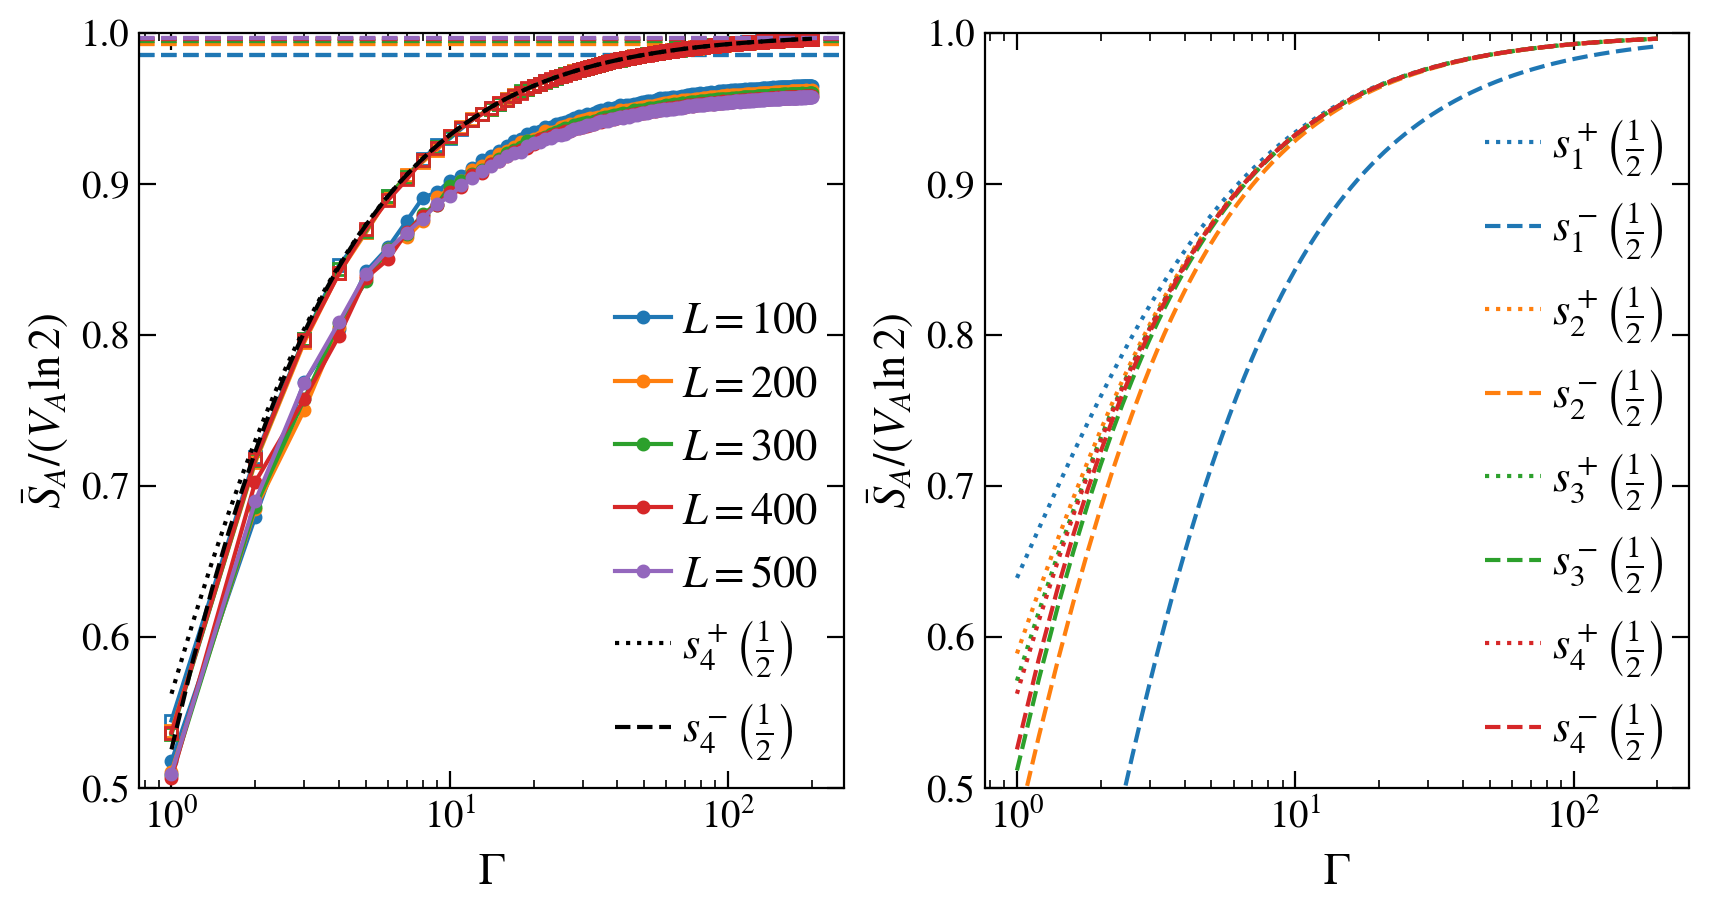

In [138]:
L = 200
w = 1
J = 1
g = 1.618



fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)

axis = ax[0]
axis2 = ax[1]
# ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.5, 0.46, 0.46])

gams = np.linspace(1, 200, 1000)

colors_ls_cyc = itertools.cycle(colors_ls)
for L in np.arange(100, 600, 100):
    col = next(colors_ls_cyc)
    for op in [0, 1]:
    # if True:
        V = L
        

        name = base_dir(model='FreeFermions', d=1) + 'Entropy/Degeneracy/'
        if op == 0:     name += "E=0,Q=0/"
        elif op == 2:   name += "AllStates/"
        else:           name += "RandomChoice/"
        name +=  info(L=L, J=J, model='FreeFermions', ext='_jobid=0.hdf5')
        # print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                S = np.array(file.get('entropy'))[0]
                if op == 0: 
                    pl = axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='o', markersize=4, label=r"$L=%d$"%(L))
                else:
                    pl = axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='s', markerfacecolor='None', markersize=4)
        else:
            print(name)
        # ax_inset.plot(4 * w_vals, ydata, marker='o', markersize=4, label=r"$L=%d$"%(L))
        axis.axhline(y = 1 - 1. / (V*np.log(2)), color=pl[0].get_color(), ls='--')

def G(x):
    return 2 / (1+x)

def leading_terms(f, x, n=4):
    res = terms(f, 1)/2 * G(x)**1
    if n >= 2:  res += terms(f, 2)/12 * G(x)**2
    if n >= 3:  res += terms(f, 3)/30 * G(x)**3
    if n >= 4:  res += terms(f, 4)/56 * G(x)**4
    # ..... other terms
    return res

n = 4   # correction order

axis.plot(gams, 1 - leading_terms(1/2, gams, n=n) / (np.log(2)), ls=':', color='k', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
axis.plot(gams, 1 - (leading_terms(1/2, gams, n=n) + terms(1/2, n) * correction(n=n) * G(gams)**n) / (np.log(2)), ls='--', color='k', label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)


fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Gamma$", font_size=14, set_legend=True, ylim=(0.5, 1.0), xscale='log')
axis.legend(loc = 'lower right', columnspacing=0.4, frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02,-0.02))


n=1
p = axis2.plot(gams, 1 - leading_terms(1/2, gams, n=n) / (np.log(2)), ls=':', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
axis2.plot(gams, 1 - (leading_terms(1/2, gams, n=n) + terms(1/2, n) * correction(n=n) * G(gams)**n ) / (np.log(2)), ls='--', color=p[0].get_color(), label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)
n=2
p = axis2.plot(gams, 1 - leading_terms(1/2, gams, n=n) / (np.log(2)), ls=':', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
axis2.plot(gams, 1 - (leading_terms(1/2, gams, n=n) + terms(1/2, n) * correction(n=n) * G(gams)**n ) / (np.log(2)), ls='--', color=p[0].get_color(), label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)
n=3
p = axis2.plot(gams, 1 - leading_terms(1/2, gams, n=n) / (np.log(2)), ls=':', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
axis2.plot(gams, 1 - (leading_terms(1/2, gams, n=n) + terms(1/2, n) * correction(n=n) * G(gams)**n ) / (np.log(2)), ls='--', color=p[0].get_color(), label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)
n=4
p = axis2.plot(gams, 1 - leading_terms(1/2, gams, n=n) / (np.log(2)), ls=':', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
axis2.plot(gams, 1 - (leading_terms(1/2, gams, n=n) + terms(1/2, n) * correction(n=n) * G(gams)**n ) / (np.log(2)), ls='--', color=p[0].get_color(), label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)


fig_help.set_plot_elements(axis2, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Gamma$", font_size=14, set_legend=True, ylim=(0.5, 1.0), xscale='log')
axis2.legend(loc = 'lower right', columnspacing=0.4, frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02,-0.02))

# COMPARE MODELS

In [26]:

# XYZ stuff
def info_base(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0):
    arr = [J1, J2, delta1, delta2, eta1, eta2, hx, hz]
    names = ['J1', 'J2','d1', 'd2', 'e1', 'e2', 'hx', 'hz']
    info = "_L=%d"%L
    for i, var in enumerate(arr):
        n = order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info

def info_sym(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0, k=0, p=1, zx=1, zz=1, edge = False):
    info = info_base(L, J1, J2, delta1, delta2, eta1, eta2, hx, hz)
    info += ",k=%d"%k
    if (k==0 or k==L/2):                                info += ",p=%d"%p
    if hz == 0 and not edge and (L % 2 == 0 or hx != 0):info += ",zx=%d"%zx
    if hx == 0:                                         info += ",zz=%d"%zz
    info += ",edge=%d"%edge
    return info

parity_sectors = [-1, 1]
def get_sectors(L, hx, hz):
    translation_real_sectors = [0, L // 2]
    translation_imag_sectors = range(1, L // 2 + L % 2)
    
    spin_flip_Z_sectors = [-1, 1] if hx == 0 else [1]
    spin_flip_X_sectors = [-1, 1] if hz == 0 and (L % 2 == 0 or hx != 0) else [1]

    real_sectors = [[ks, ps, zx, zz] for ks in translation_real_sectors for ps in parity_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]
    imag_sectors = [[kx, 1, zx, zz] for kx in translation_imag_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]

    return real_sectors, imag_sectors


def info_dis(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0, w=0, pb=0, edge = False):
    info = info_base(L, J1, J2, delta1, delta2, eta1, eta2, hx, hz)
    n = order_of_magnitude(w)
    info +=  str(",w={:.%df}"%n).format(round(w, n))
    info += ",edge=%d"%edge
    info += ",pb=%d"%pb
    return info

../results/FreeFermions/dim=1/PBC/Entropy/Degeneracy/_L=18,J=1_jobid=0.hdf5
waaaaaaa 29144.0 262144
512 9
512 9


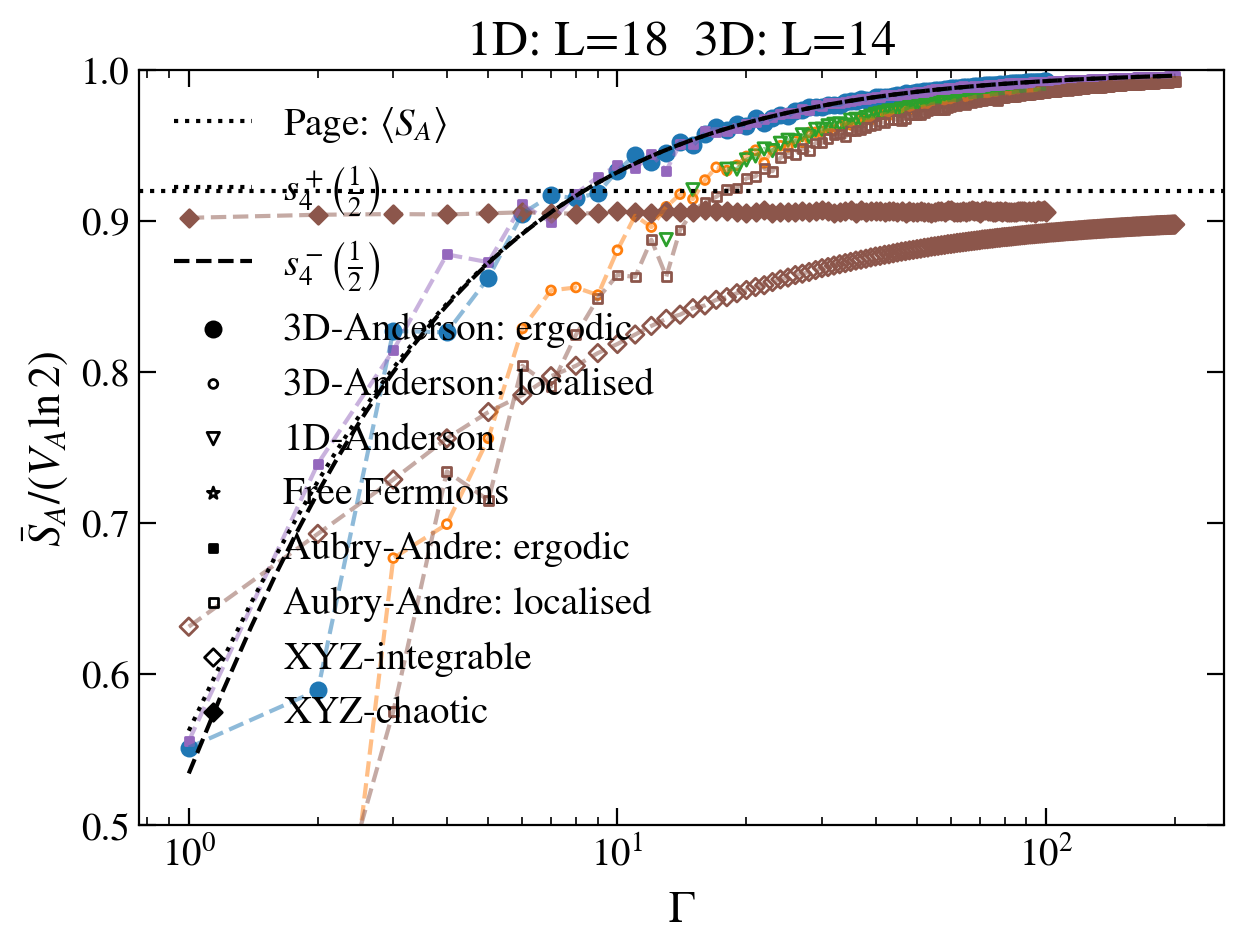

In [254]:
L = 16
w = 6
J = 1
DIM=3


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(7,5), dpi = 200)

# ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.5, 0.46, 0.46])

colors_ls_cyc = itertools.cycle(colors_ls)
for L in [L]:
# for L in [20, 50, 100, 500, 1000, 2000]:
    V = L**DIM
    
    col = next(colors_ls_cyc)

    name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model='Anderson', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='o', s=30)
            axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='o', s=30, label='3D-Anderson: ergodic')

w=27
for L in [L]:
# for L in [20, 50, 100, 500, 1000, 2000]:
    V = L**DIM
    
    col = next(colors_ls_cyc)

    name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model='Anderson', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='o', facecolor='None', s=10)
            axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='o', s=10, facecolor='None', label='3D-Anderson: localised')





L=18
w=6
DIM=1
# for L in np.arange(4, 16, 2):
for L in [L]:
    V = L**DIM
    
    col = next(colors_ls_cyc)

    name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model='Anderson', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='v', facecolor='None', s=20)
            axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='v', facecolor='None', s=20, label='1D-Anderson')

for L in [L]:
    V = L
    
    col = next(colors_ls_cyc)

    name = base_dir(model='FreeFermions', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, model='FreeFermions', ext='_jobid=0.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))[0]
            axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='*', facecolor='None', s=20)
            axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='*', facecolor='None', s=20, label='Free Fermions')

w=1
g=0.618
for L in [L]:
    V = L
    
    col = next(colors_ls_cyc)

    name = base_dir(model='AubryAndre', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, g=g, model='AubryAndre', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='s', s=10)
            axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='s', s=10, label='Aubry-Andre: ergodic')

w=4
g=0.618
for L in [L]:
    V = L
    
    col = next(colors_ls_cyc)

    name = base_dir(model='AubryAndre', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, g=g, model='AubryAndre', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            axis.scatter(np.arange(1, S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='s', facecolor='None', s=10)
            axis.plot(np.arange(1, S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='s', facecolor='None', s=10, label='Aubry-Andre: localised')

J1=1.0
d1=0.2
e1=0.2
# for L in [L]:
#     V = L
    
#     col = next(colors_ls_cyc)

#     name = '../../XYZ/results/symmetries/PBC/Entropy/Degeneracy/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=0, p=1, zx=1, zz=1) + ".hdf5"
#     # print(name)
#     if exists(name):
#         with h5py.File(name, "r") as file:
#             S = np.array(file.get('entropy'))[V//2]
#             axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='D', facecolor='None', s=20)
#             axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
#     else:
#         print(name)

V = L
LA = L//2
real_sec, imag_sec = get_sectors(L, 0, 0)
sects = real_sec + imag_sec
dim_tot = 0
S = np.zeros((200))
# sects = [[1, 1, 1, 1]]
for [ks, ps, zxs, zzs] in sects:
    name = '../../XYZ/results/symmetries/PBC/Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
    found = True
    if exists(name):
        with h5py.File(name, "r") as file:
            energies = np.array(file.get('energies')[0])
            dim = energies.size
            dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim
    else:
        found = False

    name = '../../XYZ/results/symmetries/PBC/Entropy/Degeneracy/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
    if found and exists(name):
        with h5py.File(name, "r") as file:
            entropies = np.array(file.get('entropy'))[L//2]
            S += dim * entropies if ks == 0 or ks == L / 2 else 2 * dim * entropies

    else:
        print("Not found:", name)
if dim_tot != 2**L:
    print("waaaaaaa", dim_tot, 2**L)
if dim_tot > 0: S /= dim_tot
axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='D', facecolor='None', s=20)
axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
axis.scatter(np.nan, np.nan, color='k', marker='D', facecolor='None', s=20, label=r'XYZ-integrable')

J2=1.0
d2=0.2
e2=0.2
S = np.zeros((100))
dim_tot=0
for [ks, ps, zxs, zzs] in real_sec:
    name = '../../XYZ/results/symmetries/PBC/Entropy/Degeneracy/' + info_sym(L=L, J1=J1, J2=J2, delta1=d1, delta2=d2, eta1=e1, eta2=e2, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
    if exists(name):
        with h5py.File(name, "r") as file:
            entropies = np.array(file.get('entropy'))[LA]
            dim = np.array(file.get('dim')[0][0])
            dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim
            S += dim * entropies if ks == 0 or ks == L / 2 else 2 * dim * entropies

    else:
        print("Not found:", name)
if dim_tot != 2**L:
    print("waaaaaaa", dim_tot, 2**L)
if dim_tot > 0: S /= dim_tot
axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='D', s=20)
axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
axis.scatter(np.nan, np.nan, color='k', marker='D', s=20, label=r'XYZ-chaotic')
axis.axhline(y = page(LA, L - LA) / (LA*np.log(2)), color='k', ls=':', label=r'Page: $\langle S_A\rangle$')

# L=12
# V=L
# LA = L//2
# d1=0.55
# e1=0.5
# J2=0.0
# d2=0.2
# e2=0.0
# hx=0.5
# w=0.7
# S = np.zeros((100))
# dim_tot=0
# name = '../../XYZ/results/disorder/PBC/Entropy/Degeneracy/' + info_dis(L=L, J1=J1, J2=J2, delta1=d1, delta2=d2, eta1=e1, eta2=e2,hx=hx,w=w) + "_jobid=0.hdf5"
# if exists(name):
#     with h5py.File(name, "r") as file:
#         S = np.array(file.get('entropy'))[LA]
# else:
#     print("Not found:", name)

# axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='X', s=20)
# axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
# axis.scatter(np.nan, np.nan, color='k', marker='X', s=20, label=r'XYZ-disordered')
  
axis.plot(gams, upper_bound(1/2, gams, n), ls=':', color='k', label=r'$s_{%d}^+\left(\frac{1}{2}\right)$'%n)
axis.plot(gams, lower_bound(1/2, gams, n), ls='--', color='k', label=r'$s_{%d}^-\left(\frac{1}{2}\right)$'%n)
axis.set_title(f"1D: L={L}\t 3D: L=14", fontsize=18)
fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Gamma$", font_size=14, set_legend=True, ylim=(0.5, 1.0), xscale='log')
# axis.legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.12,-0.02))

# fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=False, xlim=(8.0, 25.0), ylim=(0.7, 1.0))

fig.subplots_adjust(wspace = 0.2, hspace=0.05)
plt.savefig("PLOTS/Fig_quadratic_scaling_degenerate.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("PLOTS/Fig_quadratic_scaling_degenerate.png", bbox_inches = 'tight', pad_inches=0.02)